In [1]:
import pandas as pd
import os
import ast

def parse_metrics(file_path):
    metrics = {}
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            key, value = line.split(':', 1)
            key = key.strip()
            value = value.strip()
            if key == 'Test Accuracy':
                metrics['accuracy'] = float(value)
            else:
                value_dict = ast.literal_eval(value)
                for sub_key, sub_value in value_dict.items():
                    metrics[f'{key.lower()}_{sub_key}'] = sub_value
    return metrics

def calc_fscore(p, r):
    if p + r == 0:
        return 0  
    return 2 * (p * r) / (p + r)

def collect_data_from_files(directory):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            file_path = os.path.join(directory, filename)
            metrics = parse_metrics(file_path)
            
            metrics['file_name'] = filename
            
            unique_classes = [key.split('_')[1] for key in metrics if key.startswith('precision')]

            for c in unique_classes:
                 metrics['F1_' + c] = calc_fscore(metrics['precision_'+ c], metrics['recall_'+ c])
            data.append(metrics)

            
    return data

def extract_first_word(s):
    parts = s.split('_')
    if len(parts) > 1 and parts[1].isdigit():
        return f"{parts[0]}_{parts[1]}"
    return parts[0]

In [2]:
data_roberta2 = collect_data_from_files('encoder_models/Roberta_2/')
data_roberta = collect_data_from_files('encoder_models/Roberta/')
data_bert2 = collect_data_from_files('encoder_models/BERT_2/')
data_bert = collect_data_from_files('encoder_models/BERT/')
df_precision_gpt = pd.read_excel('decoder_models/gpt_precision.xlsx')
df_recall_gpt = pd.read_excel('decoder_models/gpt_recall.xlsx')
df_f1_gpt = pd.read_excel('decoder_models/gpt_f1.xlsx')

In [3]:
df = pd.DataFrame(data_roberta2 + data_roberta + data_bert2+ data_bert) 
df.loc[:,'model'] = [extract_first_word(file_name) for file_name in df['file_name']]
measure_cols = 'accuracy', 'precision_0', 'precision_1', 'recall_0', 'recall_1', 'F1_0', 'F1_1'
df_flat = pd.DataFrame([{'measure': c, 'value': row[c], 'model': row['model'] } for i, row in df.iterrows() for c in measure_cols])

In [4]:
df_precision = df_flat[df_flat['measure'].isin(['precision_0','precision_1'])]
df_recall = df_flat[df_flat['measure'].isin(['recall_0','recall_1'])]
df_f1 = df_flat[df_flat['measure'].isin(['F1_0','F1_1'])]
df_accuracy = df_flat[df_flat['measure'].isin(['accuracy'])]

df_precision_all = pd.concat([df_precision,df_precision_gpt[['measure', 'value', 'model']]])
df_recall_all = pd.concat([df_recall,df_recall_gpt[['measure', 'value', 'model']]])
df_f1_all = pd.concat([df_f1,df_f1_gpt[['measure', 'value', 'model']]])

In [5]:
f1_avg = df_f1_all.groupby(['measure','model']).mean().reset_index()

In [6]:
f1_avg

,measure,model,value
0,F1_0,BERT,0.874325
1,F1_0,BERT_2,0.836264
2,F1_0,Meta,0.581183
3,F1_0,Mistral,0.592353
4,F1_0,Roberta,0.875782
5,F1_0,Roberta_2,0.842130
6,F1_0,chatgpt,0.766615
7,F1_0,chatgpt ICL,0.751805
8,F1_1,BERT,0.527487
9,F1_1,BERT_2,0.579086


In [7]:
print(f1_avg[f1_avg['model'].isin(['BERT', 'BERT_2',  'Roberta','Roberta_2' ]) & (f1_avg['measure'] == 'F1_0')]['value'].mean(),
f1_avg[f1_avg['model'].isin(['BERT', 'BERT_2',  'Roberta','Roberta_2' ]) & (f1_avg['measure'] == 'F1_1')]['value'].mean(),
f1_avg[f1_avg['model'].isin(['chatgpt','chatgpt ICL', 'Mistral',  'Meta' ]) & (f1_avg['measure'] == 'F1_0')]['value'].mean(),
f1_avg[f1_avg['model'].isin(['chatgpt','chatgpt ICL', 'Mistral',  'Meta']) & (f1_avg['measure'] == 'F1_1')]['value'].mean())

0.8571250101182565 0.5740075128200116 0.6729890641674929 0.3959868343040823


In [8]:
print(f1_avg[f1_avg['model'].isin(['BERT', 'BERT_2',  'Roberta','Roberta_2' ]) & (f1_avg['measure'] == 'F1_0')]['value'].std(ddof=1),
f1_avg[f1_avg['model'].isin(['BERT', 'BERT_2',  'Roberta','Roberta_2' ]) & (f1_avg['measure'] == 'F1_1')]['value'].std(ddof=1),
f1_avg[f1_avg['model'].isin(['chatgpt', 'chatgpt ICL','Mistral',  'Meta' ]) & (f1_avg['measure'] == 'F1_0')]['value'].std(ddof=1),
f1_avg[f1_avg['model'].isin(['chatgpt', 'chatgpt ICL','Mistral',  'Meta']) & (f1_avg['measure'] == 'F1_1')]['value'].std(ddof=1))

0.020848090913483767 0.036249508399871934 0.09984690719429012 0.05690627840726693


In [9]:
import numpy as np
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [10]:
df_f1_all['model'] = df_f1_all['model'].replace({'Meta': 'Llama', 'BERT':'BERT_1', 'Roberta':'RoBERTa_1', 'Roberta_2':'RoBERTa_2', 'chatgpt': 'ChatGPT', 'chatgpt ICL': 'ChatGPT ICL'})
df_recall_all['model'] = df_recall_all['model'].replace({'Meta': 'Llama', 'BERT':'BERT_1', 'Roberta':'RoBERTa_1', 'Roberta_2':'RoBERTa_2', 'chatgpt': 'ChatGPT', 'chatgpt ICL': 'ChatGPT ICL'})
df_precision_all['model'] = df_precision_all['model'].replace({'Meta': 'Llama', 'BERT':'BERT_1', 'Roberta':'RoBERTa_1', 'Roberta_2':'RoBERTa_2', 'chatgpt': 'ChatGPT', 'chatgpt ICL': 'ChatGPT ICL'})
df_recall_all['measure'] = df_recall_all['measure'].replace({'recall_0': 'class 0', 'recall_1': 'class 1'})
df_precision_all['measure'] = df_precision_all['measure'].replace({'precision_0': 'class 0', 'precision_1': 'class 1'})

In [11]:
def convert_data_tests(df, measure):

    df_measure =df.reset_index()[['measure', 'value', 'model']]
    
    scores = {}
    measure_class = df_measure['measure'].unique()
    for measure_name in measure_class:
        scores[measure_name] = []
        for model_name in df_measure['model'].unique():
            scores[measure_name].append(df_measure[(df_measure['measure'] == measure_name) & ((df_measure['model'] == model_name))]['value'].to_list())

    scores[measure+'-avg'] = [[(scores[measure_class[0]][i][j] + scores[measure_class[1]][i][j])/2  for j in range(len(scores[measure_class[1]][i]))] for i in range(len(df_measure['model'].unique()))]

    return scores

def calculate_nemenyi_test(scores, k, column_names):
    df = pd.DataFrame(np.array(scores[k]).T, columns=column_names)

    #ranks = df.rank(axis=1, ascending=False)

    result = sp.posthoc_nemenyi_friedman(df)
    return result

def print_heatmap(scores, column_names):
    for k in scores.keys():
        result =calculate_nemenyi_test(scores, k, column_names)
                                
        colors = [ 
        "#fc8d62", 
        "#e5c494",  
        '#f5f5f5'
        ]
        custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

        plt.figure(figsize=(3, 3)) 
        ax = sns.heatmap(result,  annot=True, cmap=custom_cmap, cbar=True, fmt=".3f", annot_kws={"size": 7}) 
        ax.set_title('P-values for Nemenyi Test', fontsize=8)
        plt.xticks(fontsize=8)  
        plt.yticks(fontsize=8, rotation=0) 
        plt.show()

## Heatmaps F-scores

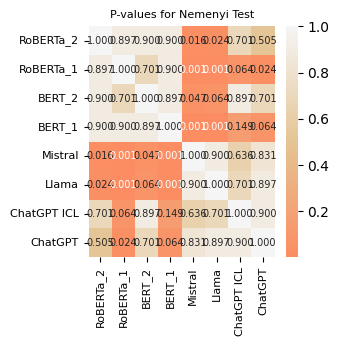

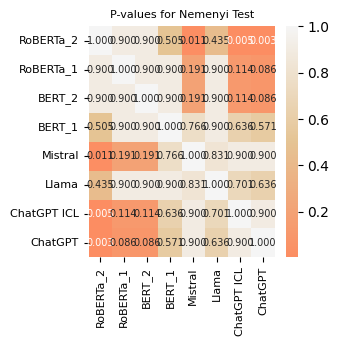

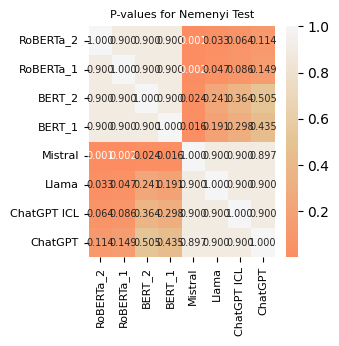

(35.04761904761904, 1.0956295562685002e-05)

In [12]:
f1_scores = convert_data_tests(df_f1_all, 'F')
stat, p = friedmanchisquare(*np.array(f1_scores['F-avg']))

print_heatmap(f1_scores,df_f1_all['model'].unique())
stat, p

## Heatmaps Precision

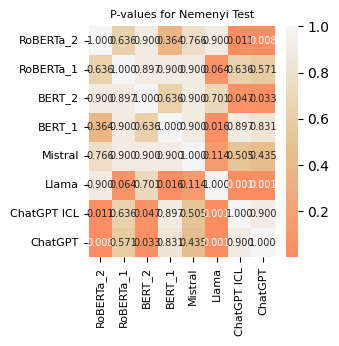

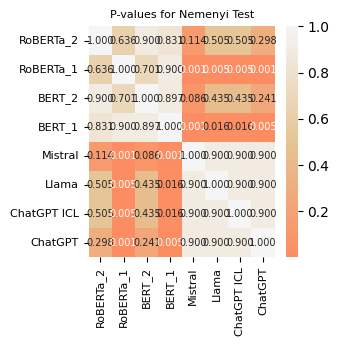

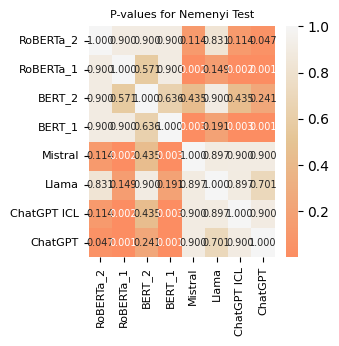

(41.38095238095238, 6.840535164604235e-07)

In [13]:
precision_scores = convert_data_tests(df_precision_all, 'P')

print_heatmap(precision_scores,df_precision_all['model'].unique())
stat, p = friedmanchisquare(*np.array(precision_scores['P-avg']))
stat, p

## Heatmaps Recall

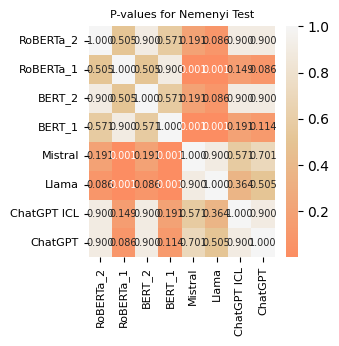

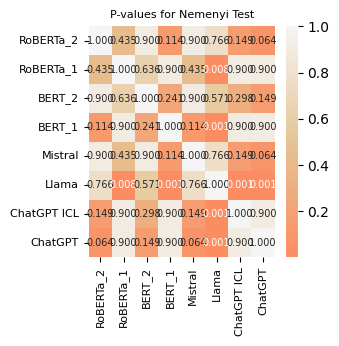

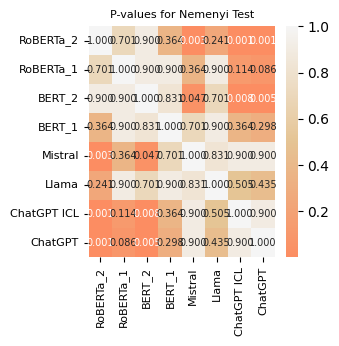

(38.428571428571416, 2.5114911718848465e-06)

In [14]:
recall_scores = convert_data_tests(df_recall_all, 'R')

print_heatmap(recall_scores,df_recall_all['model'].unique())
stat, p = friedmanchisquare(*np.array(recall_scores['R-avg']))
stat, p

## Combined heatmaps

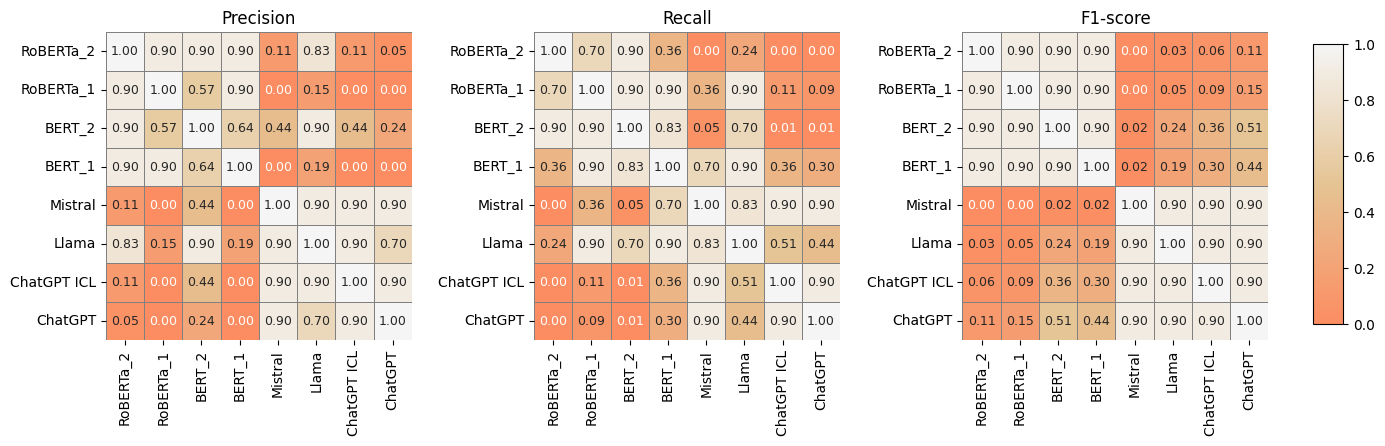

In [15]:
data_f1 = calculate_nemenyi_test(f1_scores, 'F-avg', df_f1_all['model'].unique()) # np.random.rand(10, 10) 
data_p = calculate_nemenyi_test(precision_scores, 'P-avg', df_precision_all['model'].unique())  #np.random.rand(10, 10)
data_r = calculate_nemenyi_test(recall_scores, 'R-avg', df_recall_all['model'].unique())  #np.random.rand(10, 10)


fig, axes = plt.subplots(1, 3, figsize=(15, 4))

colors = ["#fc8d62", "#e5c494", '#f5f5f5'] 
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Plotting each heatmap
sns.heatmap(data_p, ax=axes[0], cmap=custom_cmap, cbar = False, linewidths=0.4,linecolor='gray', annot=True, fmt=".2f", annot_kws={"size": 9})
axes[0].set_title('Precision')

sns.heatmap(data_r, ax=axes[1], cmap=custom_cmap, cbar = False,linewidths=0.4, linecolor='gray', annot=True, fmt=".2f", annot_kws={"size": 9})
axes[1].set_title('Recall')

sns.heatmap(data_f1, ax=axes[2], cmap=custom_cmap, cbar = False,linewidths=0.4, linecolor='gray', annot=True, fmt=".2f", annot_kws={"size": 9})
axes[2].set_title('F1-score')

# Adjust layout
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(0, 1), cmap=custom_cmap), cax=cbar_ax)


plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.savefig("RQ2-1-heatmap.pdf", format="pdf", pad_inches = 0.01, bbox_inches = 'tight')
plt.show()


## Boxplots recall (+ presicion)

In [16]:
df_precision_all['measure'] = df_precision_all['measure'].replace('class 0', 'class 0\n no requirement')
df_precision_all['measure'] = df_precision_all['measure'].replace('class 1', 'class 1\n requirement')
df_recall_all['measure'] = df_recall_all['measure'].replace('class 0', 'class 0\n no requirement')
df_recall_all['measure'] = df_recall_all['measure'].replace('class 1', 'class 1\n requirement')

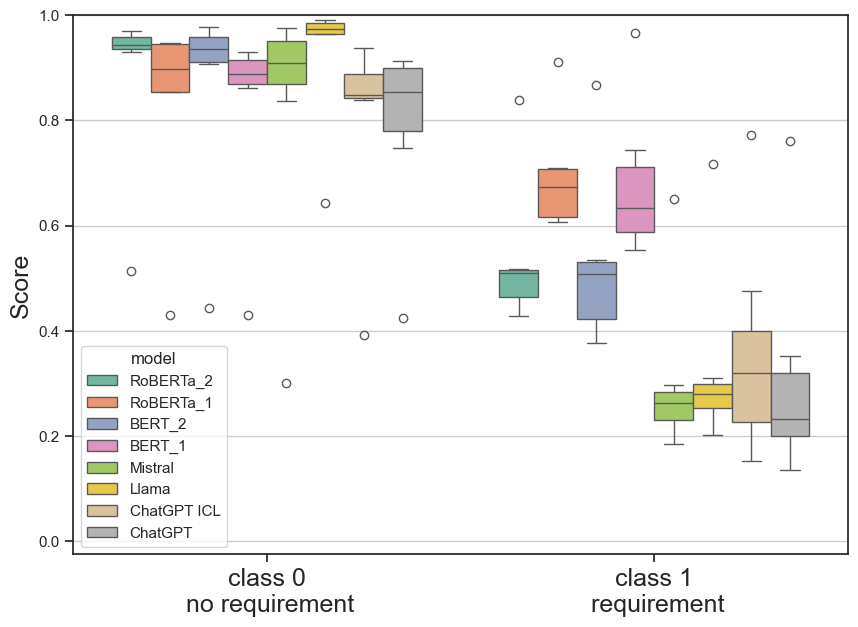

In [17]:
plt.figure(figsize=(10, 7))
custom_palette = [ "#fc8d62",  "#a6d854", "#ffd92f", "#e5c494", "#b3b3b3"]

#sns.set(style="ticks", palette=custom_palette)
sns.set(style="ticks", palette='Set2')
g= sns.boxplot(data= df_precision_all, x= 'measure', y = 'value', hue = 'model', width=0.8)
#plt.title('Performance across models: Precision', fontsize=20)
plt.ylabel('Score', fontsize=18)
plt.grid(axis='y')
plt.xlabel('', fontsize=18)
plt.ylim(-0.025,1)
plt.setp(g.get_xticklabels(), fontsize=18)
#plt.savefig("RQ2-1-precision.pdf", format="pdf", pad_inches = 0.01, bbox_inches = 'tight')
plt.show()

<Figure size 1000x700 with 0 Axes>

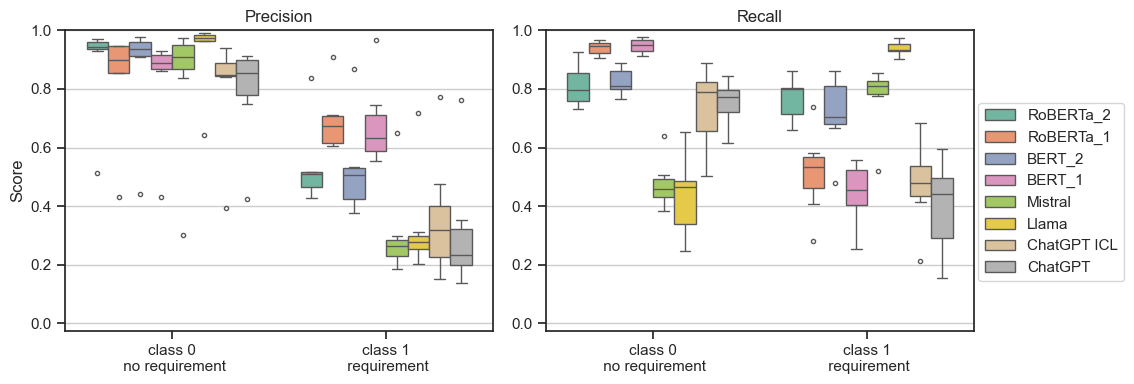

In [18]:
plt.figure(figsize=(10, 7))
custom_palette = [ "#fc8d62",  "#a6d854", "#ffd92f", "#e5c494", "#b3b3b3"]
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
flierprops = dict(marker='o', markersize=3)

sns.set(style="ticks", palette='Set2')

sns.boxplot(data= df_precision_all, ax=axes[0], x= 'measure', y = 'value', hue = 'model', width=0.8, flierprops = flierprops)

axes[0].set_title('Precision')
axes[0].set_ylabel('Score', fontsize=12)
axes[0].grid(axis='y')
axes[0].set_xlabel('', fontsize=18)
axes[0].set_ylim(-0.025,1)
sns.boxplot(data= df_recall_all, ax=axes[1], x= 'measure', y = 'value', hue = 'model', width=0.8, flierprops = flierprops)


axes[1].set_title('Recall')
axes[1].set_ylabel('')
axes[1].grid(axis='y')
axes[1].set_xlabel('', fontsize=18)
axes[1].set_ylim(-0.025,1)


handles, labels = axes[0].get_legend_handles_labels()
for ax in axes:
    ax.get_legend().remove()
    
legend = fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.14, 0.5), ncol=1)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.tight_layout()
plt.savefig("RQ2-1-precision-recall.pdf", format="pdf", pad_inches = 0.01, bbox_inches = 'tight')
plt.show()